In [1]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".30"
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
import flowrec.training_and_states as state_utils
import utils.simulation2d as project
import flowrec.data as data_utils

In [2]:
results_dir = Path("../local_results/ffcnn/221127141652")
print('Does directory exist?',results_dir.exists())

Does directory exist? True


# Load results

## saved to h5

In [ ]:
with h5py.File(Path(results_dir,'results.h5'),'r') as hf:
    loss_train = np.array(hf.get("loss_train"))
    loss_val = np.array(hf.get("loss_val"))
    ux_train = np.array(hf.get("ux_train"))
    ux_val = np.array(hf.get("ux_val"))
    ux_test = np.array(hf.get("ux_test"))
    
    uy_train = np.array(hf.get("uy_train"))
    uy_val = np.array(hf.get("uy_val"))
    uy_test = np.array(hf.get("uy_test"))
    
    pb_train = np.array(hf.get("pb_train"))
    pb_val = np.array(hf.get("pb_val"))
    pb_test = np.array(hf.get("pb_test"))

    ux_train_m = np.array(hf.get("ux_train_m"))
    ux_val_m = np.array(hf.get("ux_val_m"))
    ux_test_m = np.array(hf.get("ux_test_m"))

    uy_train_m = np.array(hf.get("uy_train_m"))
    uy_val_m = np.array(hf.get("uy_val_m"))
    uy_test_m = np.array(hf.get("uy_test_m"))

    pb_train_m = np.array(hf.get("pb_train_m"))
    pb_val_m = np.array(hf.get("pb_val_m"))
    pb_test_m = np.array(hf.get("pb_test_m"))

(ntrain,nx,ny) = ux_train.shape
nval = ux_val.shape[0]
ntest = ux_test.shape[0]

In [ ]:
with h5py.File(Path(results_dir,'parameters.h5'),'r') as hf:
    layers = list(hf.get("layers"))

## saved the random seed

In [3]:
with h5py.File(Path(results_dir,'results.h5'),'r') as hf:
    loss_train = np.array(hf.get("loss_train"))
    loss_val = np.array(hf.get("loss_val"))
    randseed = hf.get("data_randseed").astype('int16')[()]
    train_test_split = list(hf.get("train_test_split"))
    x_base = hf.get("x_base").astype('int16')[()]
    triangle_base_coords = list(hf.get("triangle_base_coords"))
    data_dir = Path(hf.get("data_dir")[()].decode())


# partition data to be the same as training script
(ux,uy,pp) = project.read_data(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
[x_train,x_val,x_test], [xm_train,xm_val,xm_test] = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=True,rng=np.random.default_rng(randseed))
[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))
pb_train = project.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
pb_val = project.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
pb_test = project.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)
(ntrain,nx,ny) = ux_train.shape

In [78]:
[ux_train_m,uy_train_m,pp_train_m] = np.squeeze(np.split(xm_train,3,axis=0))
[ux_val_m,uy_val_m,pp_val_m] = np.squeeze(np.split(xm_val,3,axis=0))
[ux_test_m,uy_test_m,pp_test_m] = np.squeeze(np.split(xm_test,3,axis=0))

In [5]:
with h5py.File(Path(results_dir,'parameters.h5'),'r') as hf:
    mlp_layers = list(hf.get("mlp_layers"))
    cnn_channels = list(hf.get("cnn_channels"))
    # cnn_filter = list(hf.get("cnn_filter"))
cnn_filter = [(3,3)]

## losses

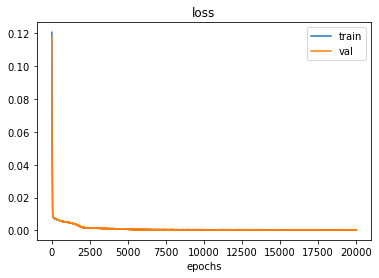

In [6]:
# loss
fig,ax = plt.subplots(1,1)
ax.plot(loss_train,label='train')
ax.plot(loss_val,label='val')
ax.set(title='loss',xlabel='epochs')
plt.legend()
plt.show()

# Get model

In [7]:
import jax
import jax.numpy as jnp
import haiku as hk
from flowrec.losses import loss_mse, mse

In [8]:
def mse_plane(x,y):
    plane = jnp.einsum('t x y-> x y', (x-y)**2) / x.shape[0]
    return plane

loss = loss_mse

In [9]:
state = state_utils.restore_trainingstate(results_dir,'state')
jax.tree_util.tree_map(lambda x: print(x.shape),state.params)

(32,)
(3, 3, 2, 32)
(16,)
(3, 3, 32, 16)
(2,)
(3, 3, 16, 2)
(98298,)
(31, 98298)


{'mlp_with_cnn/~/convolve_0': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_1': {'b': None, 'w': None},
 'mlp_with_cnn/~/convolve_2': {'b': None, 'w': None},
 'mlp_with_cnn/~/mlp/~/linear_0': {'b': None, 'w': None}}

## Feedforward

In [10]:
from flowrec.models.feedforward import Model as FeedForward

In [ ]:
mdl = FeedForward(layers)

ux_train = np.reshape(ux_train,(ntrain,-1))
ux_test = np.reshape(ux_test,(ntest,-1))
uy_train = np.reshape(uy_train,(ntrain,-1))
uy_test = np.reshape(uy_test,(ntest,-1))
u_train = np.hstack((ux_train,uy_train))
u_test = np.hstack((ux_test,uy_test))
pb_train = pb_train.reshape((ntrain,-1))
pb_test = pb_test.reshape((ntest,-1))

In [ ]:
u_train_pred = mdl.predict(state.params,pb_train)
u_test_pred = mdl.predict(state.params,pb_test)
train_loss = mse(u_train_pred,u_train)
test_loss = mse(u_test_pred,u_test)
print(f"loss for training and testing set: {train_loss:.7f}, {test_loss:.7f}.")

In [ ]:
ux_train_pred = u_train_pred[:,:nx*ny].reshape((ntrain,nx,ny))
ux_train = ux_train.reshape((ntrain,nx,ny))
ux_test_pred = u_test_pred[:,:nx*ny].reshape((ntest,nx,ny))
ux_test = ux_test.reshape((ntest,nx,ny))
uy_train_pred = u_train_pred[:,nx*ny:].reshape((ntrain,nx,ny))
uy_train = uy_train.reshape((ntrain,nx,ny))
uy_test_pred = u_test_pred[:,nx*ny:].reshape((ntest,nx,ny))
uy_test = uy_test.reshape((ntest,nx,ny))

## FF+CNN

In [132]:
from flowrec.models.cnn import Model

mdl = Model(mlp_layers=mlp_layers,output_shape=(nx,ny,2),cnn_channels=cnn_channels,cnn_filters=cnn_filter)

pb_train = np.reshape(pb_train,(train_test_split[0],-1))
u_train = np.stack((ux_train,uy_train),axis=-1)
pb_test = np.reshape(pb_test,(train_test_split[2],-1))
u_test = np.stack((ux_test,uy_test),axis=-1)
pb_val = np.reshape(pb_val,(train_test_split[1],-1))
u_val = np.stack((ux_val,uy_val),axis=-1)

In [133]:
u_train_pred = mdl.predict(state.params,pb_train)
u_test_pred = mdl.predict(state.params,pb_test)
u_val_pred = mdl.predict(state.params,pb_val)
train_loss = mse(u_train_pred,u_train)
test_loss = mse(u_test_pred,u_test)
print(f"loss for training and testing set: {train_loss:.7f}, {test_loss:.7f}.")

loss for training and testing set: 0.0003067, 0.0003136.


In [134]:
ux_train_pred = u_train_pred[...,0]
uy_train_pred = u_train_pred[...,1]
ux_test_pred = u_test_pred[...,0]
uy_test_pred = u_test_pred[...,1]
ux_val_pred = u_val_pred[...,0]
uy_val_pred = u_val_pred[...,1]

### Visualise output of feedforward layer

In [14]:
import flowrec.models.feedforward as ff
ff_mdl = ff.Model(mlp_layers)


In [15]:
mlp_params = {}
for i in range(len(mlp_layers)):
    mlp_params[f'mlp/~/linear_{i}'] = state.params[f'mlp_with_cnn/~/mlp/~/linear_{i}']


mid_u_train_pred = ff_mdl.predict(mlp_params,pb_train)

In [16]:
mid_u_train_pred = mid_u_train_pred.reshape((-1,)+u_train.shape)
mid_u_train_pred.shape

(1, 600, 381, 129, 2)

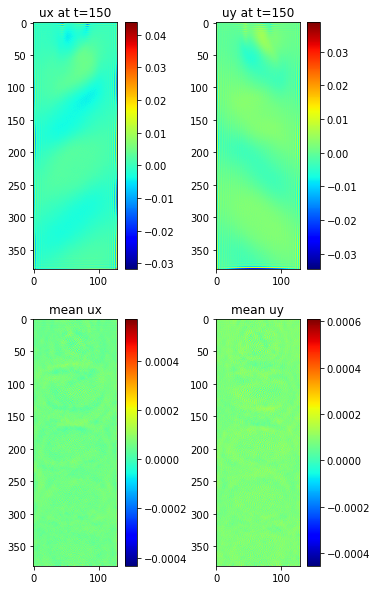

In [17]:
t = 150
fig,ax = plt.subplots(2,2,figsize=(6,10))

im00 = ax[0,0].imshow(mid_u_train_pred[0,t,:,:,0],'jet')
plt.colorbar(im00,ax=ax[0,0])
ax[0,0].set_title(f'ux at t={t}')
im01 = ax[0,1].imshow(mid_u_train_pred[0,t,:,:,1],'jet')
plt.colorbar(im01,ax=ax[0,1])
ax[0,1].set_title(f'uy at t={t}')

im10 = ax[1,0].imshow(np.mean(mid_u_train_pred[0,:,:,:,0],axis=0),'jet')
plt.colorbar(im10,ax=ax[1,0])
ax[1,0].set_title('mean ux')
im11 = ax[1,1].imshow(np.mean(mid_u_train_pred[0,:,:,:,1],axis=0),'jet')
plt.colorbar(im11,ax=ax[1,1])
ax[1,1].set_title('mean uy')
plt.show()

# Plot results

In [18]:
test_mse_ux = mse_plane(ux_test_pred,ux_test)
train_mse_ux = mse_plane(ux_train_pred,ux_train)
test_mse_uy = mse_plane(uy_test_pred,uy_test)
train_mse_uy = mse_plane(uy_train_pred,uy_train)

In [19]:
# https://www.rocq.inria.fr/modulef/Doc/GB/Guide6-10/node21.html
def relative_error(pred,true):
    err = np.sqrt(
        np.einsum('t x y -> ', (pred-true)**2)
        / np.einsum('t x y -> ', true**2)
    )
    return err

In [20]:
test_rel_ux = relative_error(ux_test_pred,ux_test)
train_rel_ux = relative_error(ux_train_pred,ux_train)
test_rel_uy = relative_error(uy_test_pred,uy_test)
train_rel_uy = relative_error(uy_train_pred,uy_train)

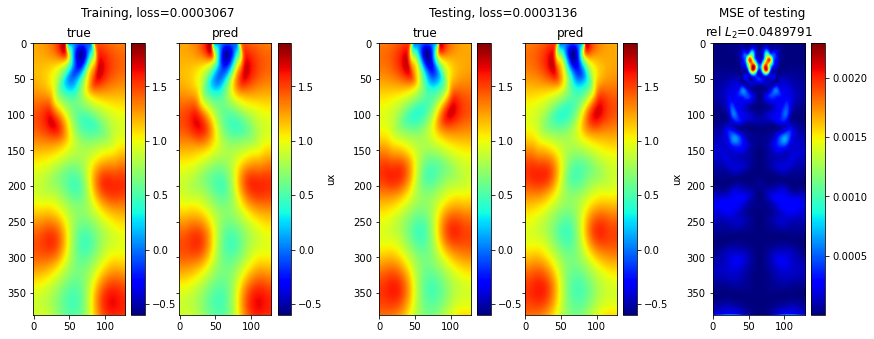

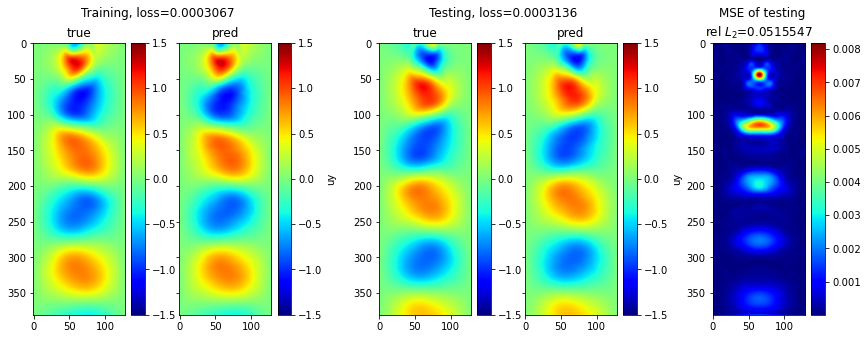

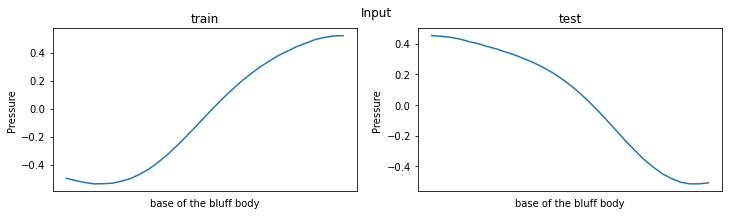

In [21]:
t = 50

# ux
fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[2,2,1])

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle(f'Training, loss={train_loss:.7f}')
im1 = axl[0].imshow(ux_train[t,:,:]+ux_train_m,'jet',vmax=1.9,vmin=-0.6)
axl[0].set_title('true')
im2 = axl[1].imshow(ux_train_pred[t,...]+ux_train_m,'jet',vmax=1.9,vmin=-0.6)
axl[1].set_title('pred')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1],label='ux')

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle(f'Testing, loss={test_loss:.7f}')
im1 = axr[0].imshow(ux_test[t,:,:]+ux_test_m,'jet',vmax=1.9,vmin=-0.6)
axr[0].set_title('true')
im2 = axr[1].imshow(ux_test_pred[t,...]+ux_test_m,'jet',vmax=1.9,vmin=-0.6)
axr[1].set_title('pred')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1],label='ux')

ax = subfigs[2].add_subplot()
im = ax.imshow(test_mse_ux,'jet')
subfigs[2].suptitle("MSE of testing")
ax.set_title(f'rel $L_2$={test_rel_ux:.7f}')
plt.colorbar(im,ax=ax)


# uy
fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[2,2,1])

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle(f'Training, loss={train_loss:.7f}')
im1 = axl[0].imshow(uy_train[t,:,:]+uy_train_m,'jet',vmax=1.5,vmin=-1.5)
axl[0].set_title('true')
im2 = axl[1].imshow(uy_train_pred[t,...]+uy_train_m,'jet',vmax=1.5,vmin=-1.5)
axl[1].set_title('pred')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1],label='uy')

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle(f'Testing, loss={test_loss:.7f}')
im1 = axr[0].imshow(uy_test[t,:,:]+uy_test_m,'jet',vmax=1.5,vmin=-1.5)
axr[0].set_title('true')
im2 = axr[1].imshow(uy_test_pred[t,...]+uy_test_m,'jet',vmax=1.5,vmin=-1.5)
axr[1].set_title('pred')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1],label='uy')

ax = subfigs[2].add_subplot()
im = ax.imshow(test_mse_uy,'jet')
subfigs[2].suptitle("MSE of testing")
ax.set_title(f'rel $L_2$={test_rel_uy:.7f}')
plt.colorbar(im,ax=ax)

# inputs
fig2,ax = plt.subplots(1,2,figsize = (12,3))
ax[0].plot(pb_train[t,:])
ax[0].set_title('train')
ax[0].set_ylabel('Pressure')
ax[0].set_xlabel('base of the bluff body')
ax[0].set_xticks([])
ax[1].plot(pb_test[t,:])
ax[1].set_title('test')
ax[1].set_ylabel('Pressure')
ax[1].set_xlabel('base of the bluff body')
ax[1].set_xticks([])
fig2.suptitle("Input")

plt.show()

# Divergence

In [ ]:
@jax.jit
def get_div_field(u,v,dx=1,dy=1):
    dudx = jnp.gradient(u,dx,axis=1)
    dvdy = jnp.gradient(v,dy,axis=2)
    div = dudx + dvdy
    return div


In [ ]:
div_train = get_div_field(ux_train_pred,uy_train_pred,12/512,4/128)
div_train_m = np.mean(div_train,axis=0)
div_train_std = np.std(div_train,axis=0)

div_test = get_div_field(ux_test_pred,uy_test_pred,12/512,4/128)
div_test_m = np.mean(div_test,axis=0)
div_test_std = np.std(div_test,axis=0)

In [ ]:
# div_train = get_div_field(ux_train,uy_train,12/512,4/128)
# div_train_m = np.mean(div_train,axis=0)
# div_train_std = np.std(div_train,axis=0)

# div_test = get_div_field(ux_test,uy_test,12/512,4/128)
# div_test_m = np.mean(div_test,axis=0)
# div_test_std = np.std(div_test,axis=0)

In [ ]:
fig = plt.figure(figsize=(10,5))
subfigs = fig.subfigures(1, 2, wspace=0.07)

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle('Divergence of Training')
im1 = axl[0].imshow(div_train_m,'jet')
axl[0].set_title(f'mean\n({np.mean(div_train):.7f})')
im2 = axl[1].imshow(div_train_std,'jet')
axl[1].set_title('standard deviation')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1])

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle('Divergence of Testing')
im1 = axr[0].imshow(div_test_m,'jet')
axr[0].set_title(f'mean\n({np.mean(div_test):.7f})')
im2 = axr[1].imshow(div_test_std,'jet')
axr[1].set_title('standard deviation')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1])
plt.show()

In [ ]:
t = 30
plt.figure(figsize=(4,6))
plt.imshow(np.abs(div_test[t,...]),'jet')
plt.colorbar(label='|div(V)|')
plt.title(f'Divergence of training at snapshot {t}')
plt.show()

# Statistics of the results

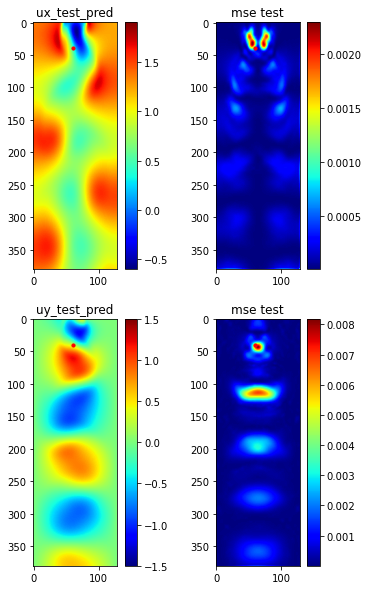

In [35]:
### probe the domain
probe_location = [40,60]

fig, ax = plt.subplots(2,2,figsize=(6,10))
im00 = ax[0,0].imshow(ux_test[t,:,:]+ux_test_m,'jet',vmax=1.9,vmin=-0.6)
ax[0,0].set_title('ux_test_pred')
plt.colorbar(im00,ax=ax[0,0])
im01 = ax[0,1].imshow(test_mse_ux,'jet')
ax[0,1].set_title('mse test')
plt.colorbar(im01,ax=ax[0,1])

im10 = ax[1,0].imshow(uy_test[t,:,:]+uy_test_m,'jet',vmax=1.5,vmin=-1.5)
ax[1,0].set_title('uy_test_pred')
plt.colorbar(im10,ax=ax[1,0])
im11 = ax[1,1].imshow(test_mse_uy,'jet')
ax[1,1].set_title('mse test')
plt.colorbar(im11,ax=ax[1,1])

for i,axi in enumerate(ax.reshape((-1))):
    axi.scatter(probe_location[1],probe_location[0],s=10,c='r')

plt.show()

## Original data

In [143]:
## Unshuffle dataset
ux_all = np.vstack((ux_train+ux_train_m, ux_val+ux_val_m, ux_test+ux_test_m))
uy_all = np.vstack((uy_train+uy_train_m, uy_val+uy_val_m, uy_test+uy_test_m))
pp_all = np.vstack((pp_train+pp_train_m, pp_val+pp_val_m, pp_test+pp_test_m))
idx = np.arange(ux_all.shape[0])
rng = np.random.default_rng(randseed)
rng.shuffle(idx)
idx_unshuffle = np.argsort(idx)


ux_all = ux_all[idx_unshuffle,:,:]
uy_all = uy_all[idx_unshuffle,:,:]
pp_all = pp_all[idx_unshuffle,:,:]


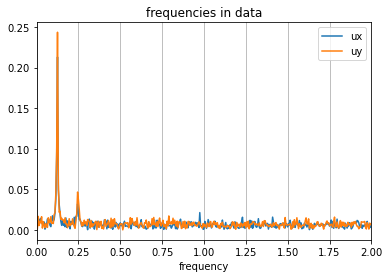

In [144]:
probe_ux = ux_all[:,probe_location[1],probe_location[0]]
probe_uy = uy_all[:,probe_location[1],probe_location[0]]
probe_p = pp_all[:,0,probe_location[0]]



freq = np.fft.fftfreq(len(probe_ux),d=0.0002*1250)
f_ux = np.fft.fft(probe_ux-np.mean(probe_ux))/len(probe_ux)
f_uy = np.fft.fft(probe_uy-np.mean(probe_uy))/len(probe_uy)
f_p = np.fft.fft(probe_p-np.mean(probe_p))/len(probe_p)
plt.figure()
plt.plot(freq[:int(len(freq)/2)],np.abs(f_ux)[:int(len(freq)/2)],label ='ux')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_uy)[:int(len(freq)/2)],label ='uy')
# plt.plot(freq[:int(len(freq)/2)],np.abs(f_p)[:int(len(freq)/2)],label ='pp')
plt.title('frequencies in data')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.xlim([0,2])
plt.legend()
plt.grid(True, which='both', axis='x')
plt.show()

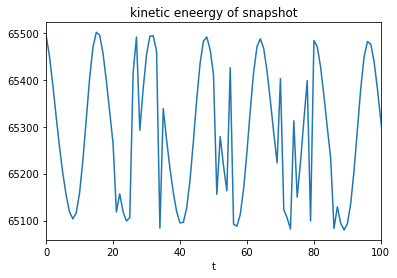

In [149]:
## kinetic energy
ke = ux_all**2 + uy_all**2
ke = np.einsum('t x y -> t',ke)

plt.figure()
plt.plot(ke)
plt.title('kinetic eneergy of snapshot')
plt.xlabel('t')
plt.xlim([0,100])
plt.show()

## Prediction

In [145]:
## Unshuffle prediction dataset
ux_all_pred = np.vstack((ux_train_pred+ux_train_m, ux_val_pred+ux_val_m, ux_test_pred+ux_test_m))
uy_all_pred = np.vstack((uy_train_pred+uy_train_m, uy_val_pred+uy_val_m, uy_test_pred+uy_test_m))
idx = np.arange(ux_all_pred.shape[0])
rng = np.random.default_rng(randseed)
rng.shuffle(idx)
idx_unshuffle = np.argsort(idx)


ux_all_pred = ux_all_pred[idx_unshuffle,:,:]
uy_all_pred = uy_all_pred[idx_unshuffle,:,:]

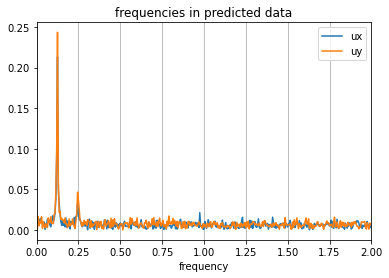

In [146]:
probe_ux_pred = ux_all_pred[:,probe_location[1],probe_location[0]]
probe_uy_pred = uy_all_pred[:,probe_location[1],probe_location[0]]



freq = np.fft.fftfreq(len(probe_ux_pred),d=0.0002*1250)
f_ux = np.fft.fft(probe_ux-np.mean(probe_ux_pred))/len(probe_ux_pred)
f_uy = np.fft.fft(probe_uy-np.mean(probe_uy_pred))/len(probe_uy_pred)
plt.figure()
plt.plot(freq[:int(len(freq)/2)],np.abs(f_ux)[:int(len(freq)/2)],label ='ux')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_uy)[:int(len(freq)/2)],label ='uy')
plt.title('frequencies in predicted data')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.xlim([0,2])
plt.legend()
plt.grid(True, which='both', axis='x')
plt.show()

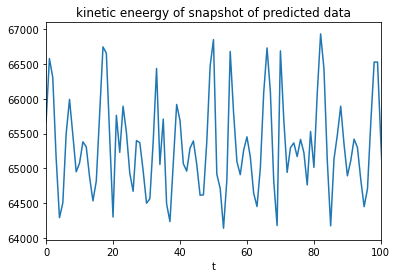

In [150]:
## kinetic energy
ke_pred = ux_all_pred**2 + uy_all_pred**2
ke_pred = np.einsum('t x y -> t',ke_pred)

plt.figure()
plt.plot(ke_pred)
plt.title('kinetic eneergy of snapshot of predicted data')
plt.xlabel('t')
plt.xlim([0,100])
plt.show()